# Project: Fairness in Classification on the COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr

## PART 1 - Analysis of COMPAS dataset
we begin this project by analysing the dataset we will be working with.


In [1]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from pylab import rcParams
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

<h1>1. Dataset exploration</h1>
In this part we will explore the ProPublica COMPAS dataset by determining the features available for exploration, labels. we will also analyse performance metrics according to race and gender available in the dataset. 
The main goal of this section is to determine and understand the features needed to build a classifier and determine if the COMPAS prediction was atually biased.

<h3>1. 1 ProPublica COMPAS dataset</h3>
we begin by either downloading or loading the dataset, and exploring its content.

In [2]:
#function to plot some graphs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

#downloading or checking for data
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

pd.options.display.max_columns = None
df=pd.read_csv('compas-scores-two-years.csv')
df

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

From the display of the datset above, we have 53 columns and 7214 rows.
Not all columns will be needed to analyse the data so we have to remove columns that will not be needed.To decide, we can display colummns having empty values to determine if they will have much much impact on the exploration or not.

In [3]:
#sum of null values per column
df.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

We can see from the data above, some columns such as r_case, r_charge_degree have a huge amount of empty values. We can't use these part of the data to build our classifier or do any analysis as it will be highly biased if those columns should have anything to do with prediction. Columns such as id and name will also not be needed to do our analysis because we will not need the name of the person to see how our classifier will perform in the next part.

<h3>1.2 Filtered Dataset</h3>
 We will first remove all columns which contain null (NaN) values, followed by listing each column with how many unique values they have.

In [4]:
#removing null values
df = df[df.columns[~df.isnull().any()]]
#unique valyes in each column
df.nunique()

id                       7214
name                     7158
first                    2800
last                     3950
compas_screening_date     690
sex                         2
dob                      5452
age                        65
age_cat                     3
race                        6
juv_fel_count              11
decile_score               10
juv_misd_count             10
juv_other_count            10
priors_count               37
c_charge_degree             2
is_recid                    2
is_violent_recid            2
type_of_assessment          1
decile_score.1             10
score_text                  3
screening_date            690
v_type_of_assessment        1
v_decile_score             10
v_score_text                3
v_screening_date          690
priors_count.1             37
start                     237
end                      1115
event                       2
two_year_recid              2
dtype: int64

By observing our result, some columns have large number of unique values. 
These may indicate that they are not highly relevant, which means we can drop them. We can also see there are some columns which only have 1 unique value, we will not use these data because we cant use it as a feature. It is same for everyone in the dataset.

According to our analysis, we select the following columns for exploration of the dataset. this totals up to 15 columns

In [5]:
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'is_recid', 
         'is_violent_recid', 'decile_score', 'score_text', 'v_decile_score', 'v_score_text', 'event', 'two_year_recid']]
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_recid,is_violent_recid,decile_score,score_text,v_decile_score,v_score_text,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,0,1,Low,1,Low,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,3,Low,1,Low,1,1
2,Male,Less than 25,African-American,0,0,4,F,1,0,4,Low,3,Low,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,0,8,High,6,Medium,0,0
4,Male,25 - 45,Other,0,0,2,F,0,0,1,Low,1,Low,0,0


In this section we begin to explore our dataset. how many race, how many people have prior crime counts, which race is mostly labelled as a risk, which age category is at a risk of being labelled high or low score.

### Race
we analyse counts per race

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

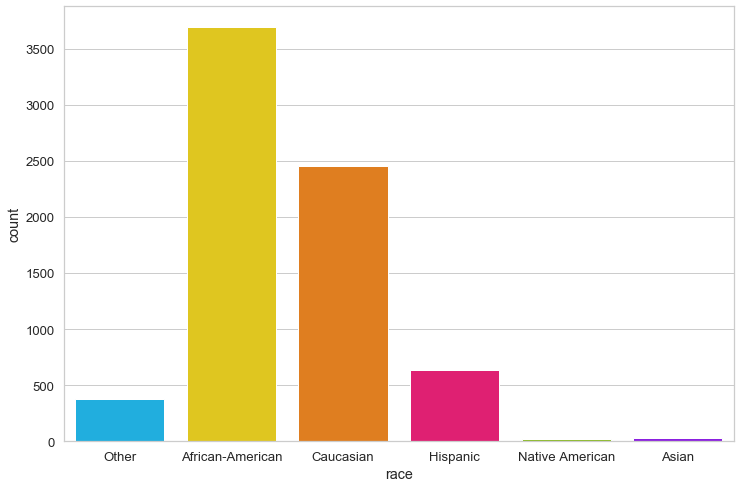

In [6]:
sns.countplot(df.race)
df.race.value_counts()

As shown above there are a total of 5 different race considered and other races labelled as "Other". African-Americans have the largest number of records followed by caucasians.we can also observe that the number of African-Americans will be almost equal to the total number of all other races combined.
races may have an effect on the result of classifier. 

we continue our analysis for other features.

### Prior Counts
below we analysis the number of people having some prior counts of crimes.

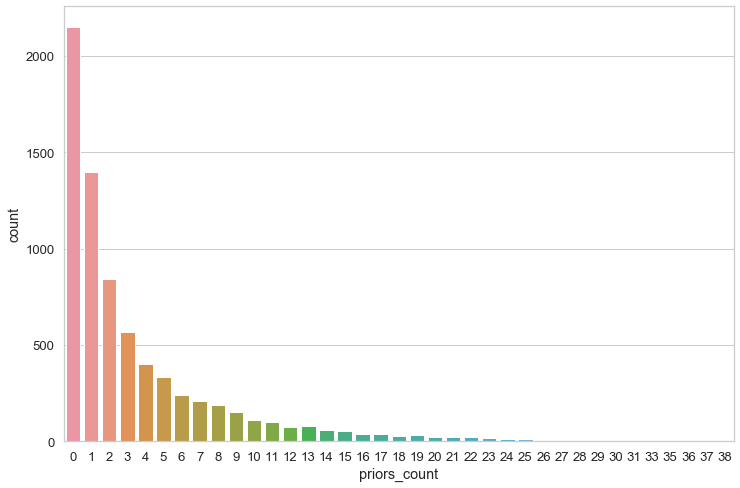

In [7]:
sns.countplot(df.priors_count)

prior_count shows how many times a number of people offended. We can see a significant number of people have no prior counts. We can take into consideration this column to access the risk of recidivism of an individual.

### Two_year Recid
we also analyse this section by race, age categories and by gender to see the distribution.
This dataset includes information about whether or not the subject recidivated in the last 2 years, and so we can directly test the accuracy of the predictions. 

In [8]:
#number of people per recid
df.two_year_recid.value_counts()

0    3963
1    3251
Name: two_year_recid, dtype: int64

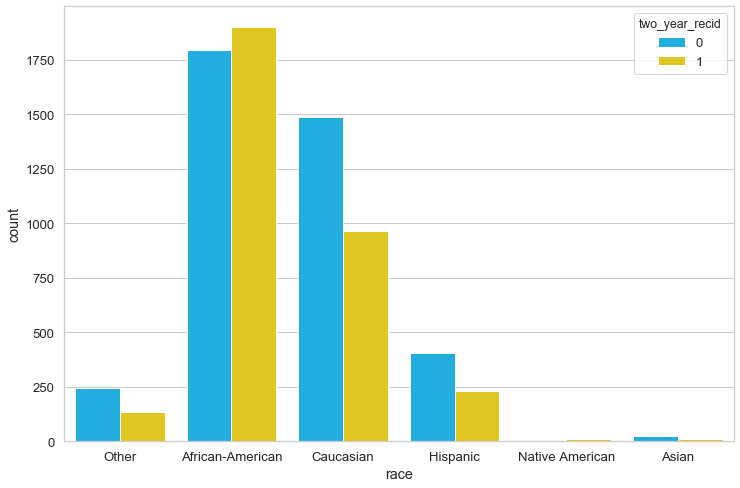

In [9]:
#Two_year Recid by race
by_race = sns.countplot(x="race", hue="two_year_recid", data=df[df.race.isin(['Caucasian','Asian','African-American', 'Hispanic','Native American', 'Other'])])

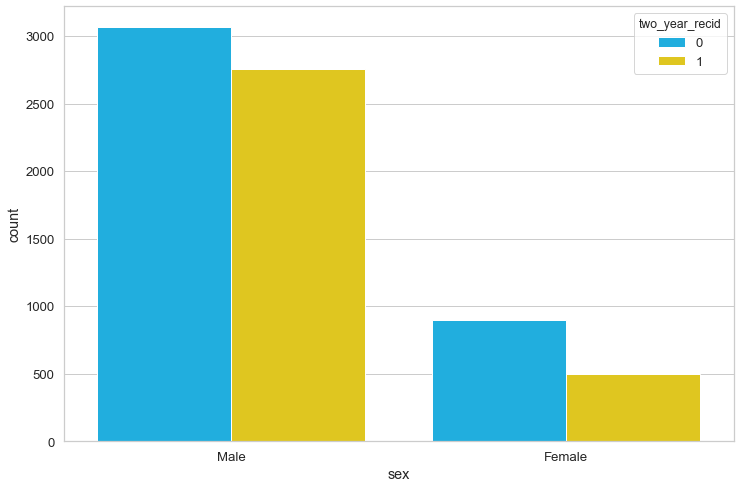

In [10]:
#Two_year Recid by sex
by_sex = sns.countplot(x="sex", hue="two_year_recid", data=df)


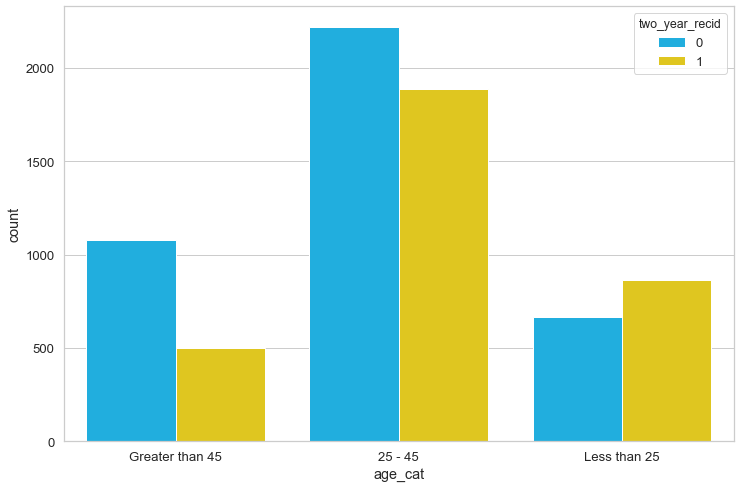

In [11]:
#Two_year Recid by age
by_age = sns.countplot(x="age_cat", hue="two_year_recid", data=df)

We can see from from graphs above give us the distribution of two_year Recid by by the various groups. The number of males and females with zero recid is higher than those with a number of recids. We can see by race that a significant number of African-Americans recidivated within the last two years as Compared to Caucasians. By age category, defendants greater than 45 years and those between 25-45 years have not committed a crime in the last two years as compared to categories of than 25 years.


### Score_text
this is used to classify people into high, medium or Low category. These labels usually indicate how dangerous a particular person is. From compas, some people from a particular race were labelled with a high score_text while their offense does not merit such a label. Others were labelled as low or medium from a particular race even though their offense was one to be labelled high. Because of this label, the compass algorithm wrongly predicts redicivsm for a certain race. we would want to see the  distribution of people according to race in these score text.

Low       3897
Medium    1914
High      1403
Name: score_text, dtype: int64

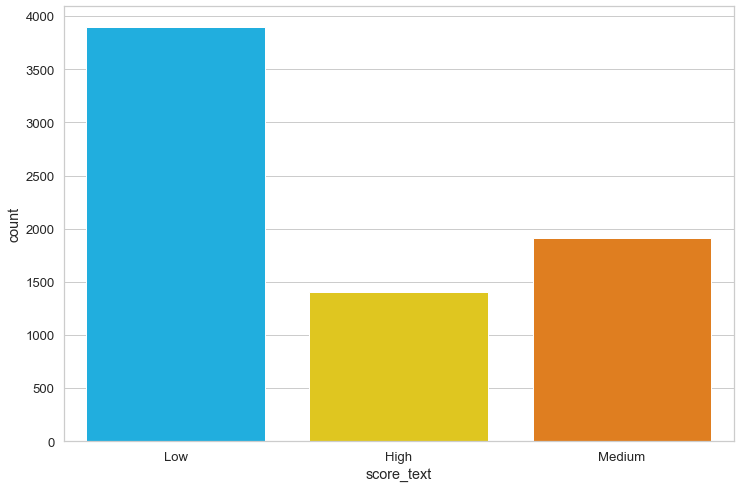

In [12]:
# number of people in each score_text
sns.countplot(df.score_text)
df.score_text.value_counts()

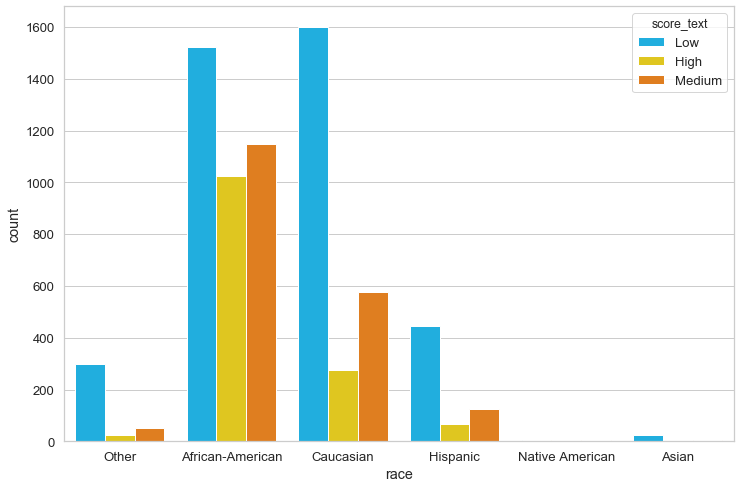

In [13]:
by_race = sns.countplot(x="race", hue="score_text", data=df[df.race.isin(['Caucasian','Asian','African-American', 'Hispanic','Native American', 'Other'])])

In the bar charts above, we see a large difference in how these scores are distributed by race, with a majority of Asians and Native-americans, others predicted as low risk (score = 0) and a majority of black people predicted high(score = 3) and medium risk (score = 2). Caucasians also have a majority predictes as high

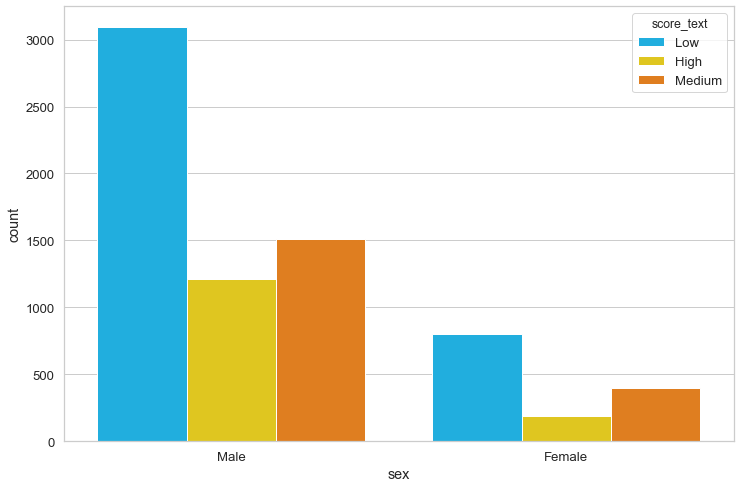

In [14]:
by_sex = sns.countplot(x="sex", hue="score_text", data=df)

we can see from above that there is ahuge disparity between the genders. More of the males were classified as high risk as compared to females.this might be as a result of the variation in count between the genders but the distribution is not fair. This means a male offender is likely to be classified as high as compared to a female for the same crime.

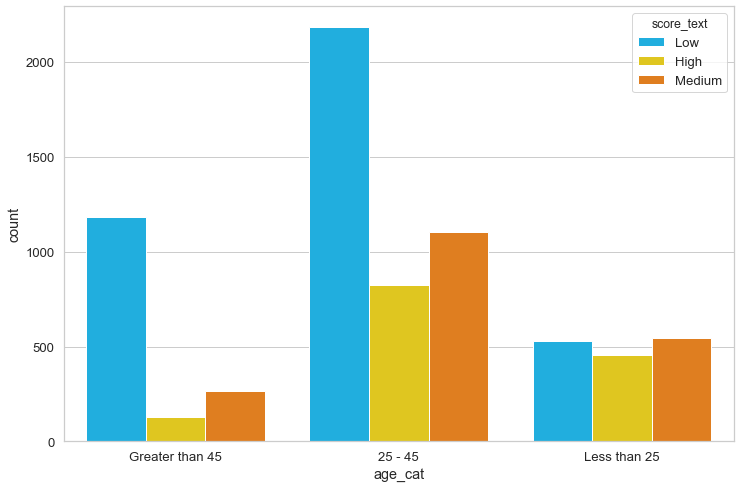

In [15]:
by_age = sns.countplot(x="age_cat", hue="score_text", data=df)

From the graphs, the number of people labelled as medium and high is far less than the number of people labelled as low. BUt our anaysis from race shows that, majority of high and medium labels were African-Americans. Even Caucasian had the highest number of low labels.
In age category, we can see a significant number of high and medium labels were for defendants between 25-45 years. Less than 25 offenders are likely to be placed into any label as they have almost the same distribution and greater than 45 are mostly labelled as a low. This might be a discrimination by age category because the likely of placing a 50 year old defendent as low while his offense deserves a high is really high.

Without considering the prior count on the graphs above, we can see Caucasian, Hispanic, Asian and other have almost a similar ditribution, Native Americans have the same ditributions accross this labels and African-Americans have a higher distribution. It should be noted that the number of people (labelled as frequency in the graph) is not the same accross the races. African-Americans have the highest number of people in this dataset.

Judges are always presented with 2 labels (one that classifies people into High, Medium and Low risk, and a corresponding decile score). 

### Decile_Scores (Risk scores)
the decile score ranges from 1 to 10 with 1 being the least probability to recidiviate and 10 being the highest.
below is a distribution of the decile scores according to the race categories


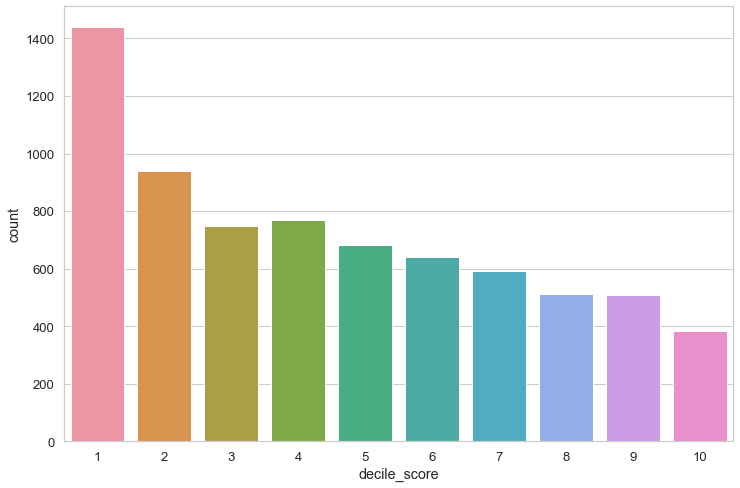

In [16]:
#number of people per decile_score
sns.countplot(df.decile_score)

The graph above shows the distribution of the number of people distibuted accorss the decile scores. This does not give a detailed information so we could continue to analyse by race.

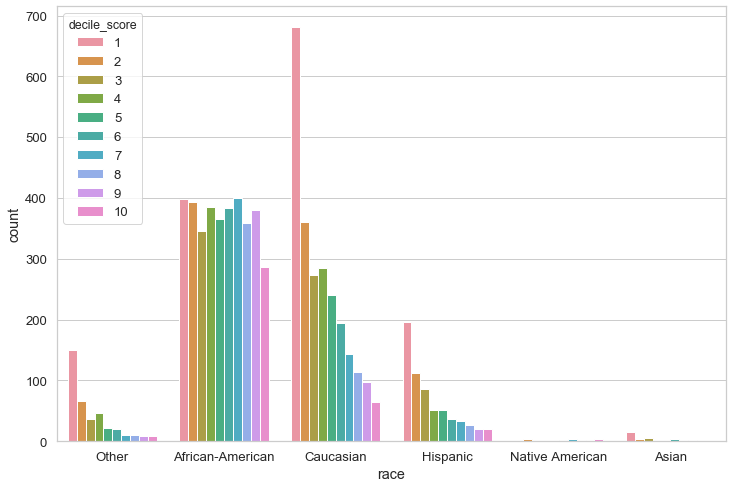

In [17]:
# decile score distribution by race
by_race = sns.countplot(x="race", hue="decile_score", data=df[df.race.isin(['Caucasian','Asian','African-American', 'Hispanic','Native American', 'Other'])])

'African-American' decile scores are almost evenly distributed. This means there is a higher chances of being classified as '8' or '10' for a crime deserving an '1'. if we look closely score of '0' and '7' is almost equal in african americans. this mentions a possibility as being mislabelled for an offense.

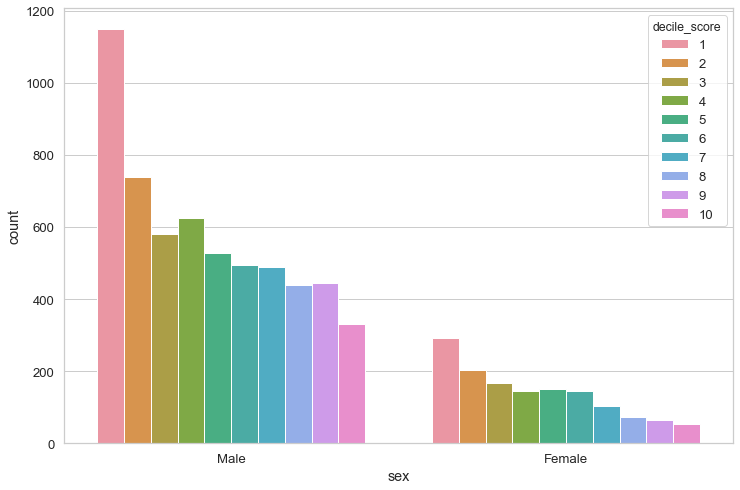

In [18]:
# decile score distribution by sex
by_sex = sns.countplot(x="sex", hue="decile_score", data=df)

Also by gender, males are likely to be given a higher score than females. In males the decile scores  equal in 6 and 7 have almost equal number of people, same for 8 and 9. Another possibility of being misclassified or mislabelled for crimes. For females, The score seems to be even from 3 to 6 so there is a possibility for a female to be laballed as any of these three.

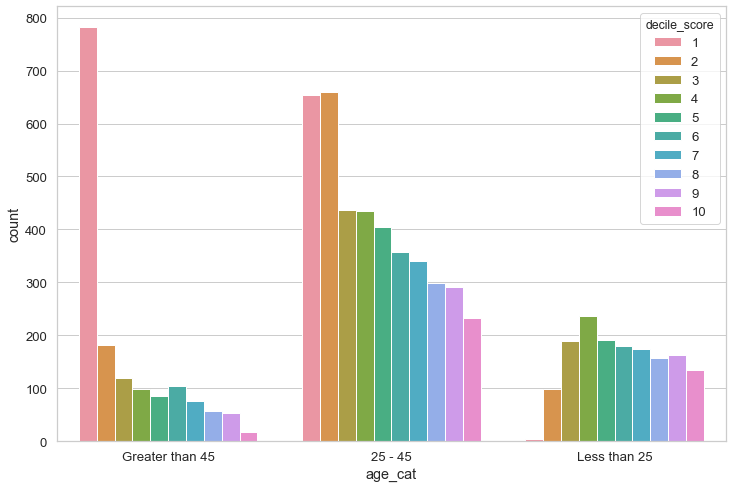

In [19]:
by_age = sns.countplot(x="age_cat", hue="decile_score", data=df)

majority of the decile score was attributed to age category of 25-45. Less than age of 25, it is high to be classified as a 2,4,5,6,7,8 or 9 because the range seems to be almost equal. Majority of greater than 45 were classified as a 1 with few classified as a 10. this shows a bias against the age category of 25-45 and less than 25.

### Compass Classifier and Performance Metrics
We will compute basic performance metrics of the COMPAS predictions in this section. As mentioned in the document, the main issue of this predictions is biased towards certain racial group.

According to COMPAS 'two_year_recid' is the ground truth which indocates whether the offenders actually recidivated or not. Therefore we can use this data to compute the accuracy of COMPAS prediction by considering value of 'score_text'. To simplify we will consider if the value of 'score_text' is 'High', it means that the classifer tells that the corresponding criminal will redivicate.<br><br>

Practically, we will first need to convert the column 'score_text' into 0 and 1 values. To simplify any 'Low' values in 'score_text' means that the compass classifier predicted the defendants to not recid (two_year_recid = 0). Then we will compute the accuracy, also other metrics such as Precision and Recall would be evaluated.

Accuracy	: 0.6537288605489326
              precision    recall  f1-score   support

           0       0.68      0.69      0.68      3897
           1       0.63      0.61      0.62      3317

    accuracy                           0.65      7214
   macro avg       0.65      0.65      0.65      7214
weighted avg       0.65      0.65      0.65      7214



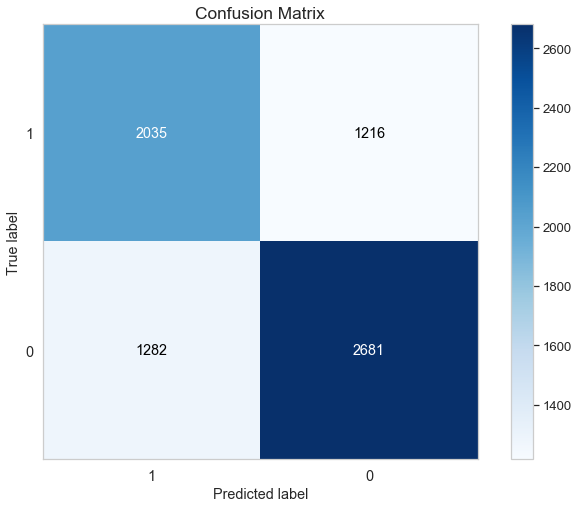

In [20]:
nparray = pd.DataFrame(df['score_text']).to_numpy()
nparray1 = pd.DataFrame(df['two_year_recid']).to_numpy()
i = 0
for x in nparray:
    if x == "Low":
        nparray[i] = 0
    else:
        nparray[i] = 1
    i = i + 1

y_pred = nparray.astype('int')
y_true = nparray1.astype('int')
print("Accuracy\t: " + str(accuracy_score(y_true, y_pred)))
print(classification_report(y_pred,y_true))
skplt.metrics.plot_confusion_matrix(y_true,y_pred, labels=[1,0])

We can see that all of the performance metric values are pretty low. The crowd based accuracy is at 65% with no race condition attached. This means not all cases were correctly classified. Precision is also based at 0.65 meaning that not all relevant instances used for the classification are not available. f1_score is the effectiveness of data classification.  it is a combination of precision and recall, best value is 1.

From the confusion matrix, we can see a greater portion of the data was misclassified from the prediction. there is a higher number of False-Negative as compared to False Positives. The number of false positives is too high. People are in this category have a higher rate of being convicted.

This indicates that the Compass prediction is poor.The factors we mentioned above might be responsible for these misclassifications.

To analyze further, we will compute the metrics for each race to see if the accuracy is evenly distributed.

In [21]:
#performance of COMPAS by race
tmpaccuracy = [0] * 6
tmpprecission = [0] * 6
tmprecall = [0] * 6
idx=0
races = df.race.unique()
for race in races:
    nparray = pd.DataFrame(df['score_text'].loc[df['race'] == race]).to_numpy()
    nparray1 = pd.DataFrame(df['two_year_recid'].loc[df['race'] == race]).to_numpy()
    i = 0
    for x in nparray:
        if x == "Low":
            nparray[i] = 0
        else:
            nparray[i] = 1
        i = i + 1
        
    y_pred = nparray.astype('int')
    y_true = nparray1.astype('int')
    print(race+" Offenders => ")
    print("Accuracy\t: " + str(accuracy_score(y_true, y_pred)))
    print("Precision\t: " + str(precision_score(y_true, y_pred)))
    print("Recall\t\t: " + str(recall_score(y_true, y_pred)) + "\n")
    tmpaccuracy[idx] = accuracy_score(y_true, y_pred)
    tmpprecission[idx] = precision_score(y_true, y_pred)
    tmprecall[idx] = recall_score(y_true, y_pred)
    idx = idx + 1

Other Offenders => 
Accuracy	: 0.6657824933687002
Precision	: 0.5443037974683544
Recall		: 0.3233082706766917

African-American Offenders => 
Accuracy	: 0.6382575757575758
Precision	: 0.6297148114075437
Recall		: 0.7201472908995266

Caucasian Offenders => 
Accuracy	: 0.6699266503667481
Precision	: 0.5913348946135831
Recall		: 0.5227743271221532

Hispanic Offenders => 
Accuracy	: 0.6609105180533752
Precision	: 0.5421052631578948
Recall		: 0.44396551724137934

Native American Offenders => 
Accuracy	: 0.7777777777777778
Precision	: 0.75
Recall		: 0.9

Asian Offenders => 
Accuracy	: 0.84375
Precision	: 0.75
Recall		: 0.6666666666666666



the performance metrics per race seems not to have a huge gap with respect to the general performance.

Participant accuracy is not significantly different for black defendants (63%) compared with Asians(84%) and Native Americans(77%). We can see African-Americans can easily be misclassified.
The scores obtained from above just itirates the fact that the predictions are not always correct and that compass most often misclassifies the criminals.

we show below the graphs of the results obtained from performance evaluation of COMPAS. Each of the graphs (accuracy, precision and recall) is plotted by race.


#### Accuracy graph

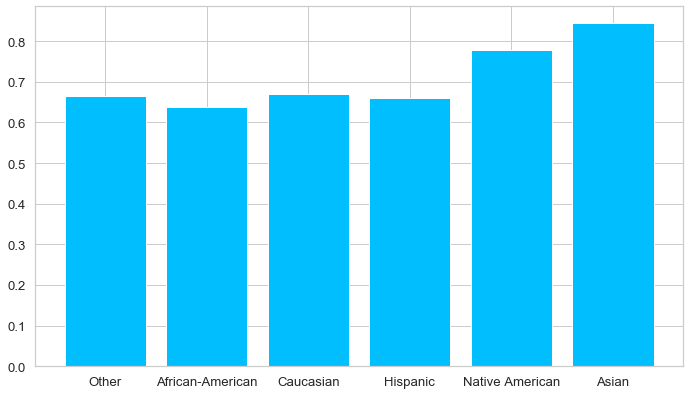

In [22]:
Race = df['race']
Race = Race.unique()
Accuracy = [tmpaccuracy[0], tmpaccuracy[1], tmpaccuracy[2], tmpaccuracy[3], tmpaccuracy[4], tmpaccuracy[5]]

fig = plt.figure()
fig.set_size_inches(9, 5)
ax = fig.add_axes([0,0,1,1])
ax.bar(Race,Accuracy)
plt.show()

####  Precision & Recall Graph

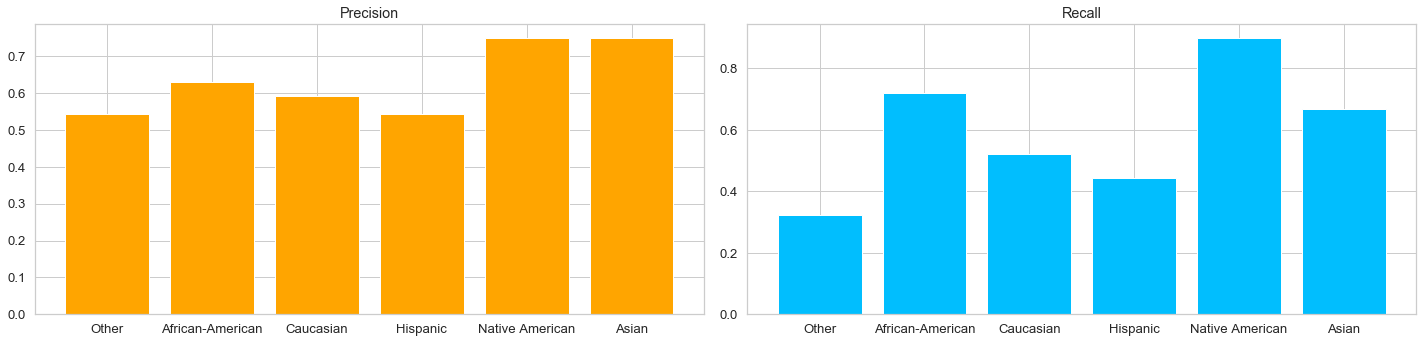

In [23]:
#Precision & Recall Graph
Precision = [tmpprecission[0], tmpprecission[1], tmpprecission[2], tmpprecission[3], tmpprecission[4], tmpprecission[5]]
Recall = [tmprecall[0], tmprecall[1], tmprecall[2], tmprecall[3], tmprecall[4], tmprecall[5]]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].set_title('Precision')
axes[0].bar(Race, Precision, color='orange')
axes[1].set_title('Recall')
axes[1].bar(Race, Recall)
fig.tight_layout()

from the precision and recall graphs, Precision is actually for Native-Americans and Asians, Recall also high for Native-Americans. we can say that the probability of mis predictiong an native american is not as significant as an african american.

###  Bias on Race
On the chart below we can see a graph based on the number of defendants by race where they labeled 'High' but didn't actually recid in two years. The next graph is showing the other way around, which is labeled 'Low' and 'two_year_recid' = 1.

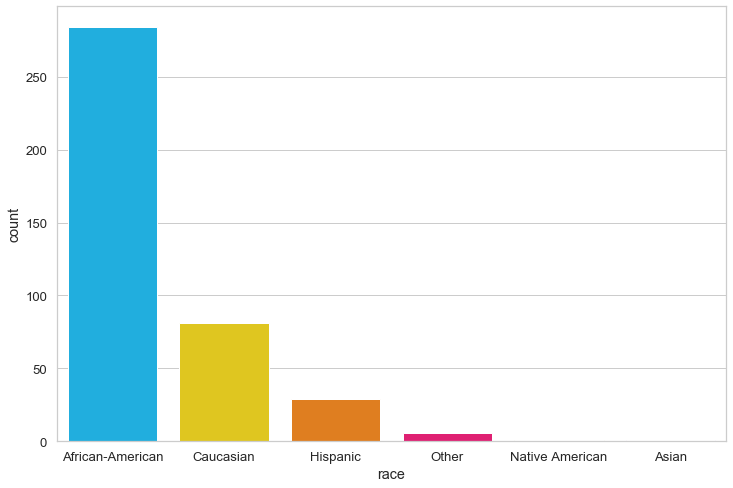

In [24]:
dfbias = df.loc[(df['two_year_recid']==0) & (df['score_text']=='High')]
sns.countplot(dfbias.race)

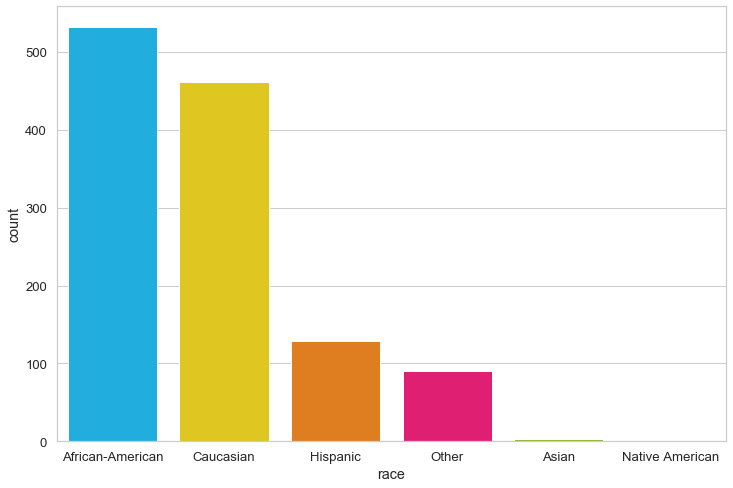

In [25]:
dfbias = df.loc[(df['two_year_recid']==1) & (df['score_text']=='Low')]
sns.countplot(dfbias.race)

From those two graph we can see that the most of the wrongly labeled defendants are 'African - American'. Other races which actually recided were labelled a low risk as compared to African-American.Also most of African-American who did not recid were labelled a high rish as compared to other races. This shows a bias in the race.

It is true that the proportion of 'African - American' defendant is much larger, however we can compute the percentage below. 

In [26]:
print("Bias for 'two_year_recid = 0' and score_text = 'High'")

total = len(df.loc[(df['race']=='African-American')])
zero_high = len(df.loc[(df['race']=='African-American') & (df['two_year_recid']==0) & (df['score_text']=='High')])
print("African-American\t = " + str(zero_high/total))

total = len(df.loc[(df['race']!='African-American')])
zero_high = len(df.loc[(df['race']!='African-American') & (df['two_year_recid']==0) & (df['score_text']=='High')])
print("Non African-American\t = " + str(zero_high/total))

print("\nBias for 'two_year_recid = 1' and score_text = 'Low'")

total = len(df.loc[(df['race']=='African-American')])
zero_high = len(df.loc[(df['race']=='African-American') & (df['two_year_recid']==1) & (df['score_text']=='Low')])
print("African-American\t = " + str(zero_high/total))

total = len(df.loc[(df['race']!='African-American')])
zero_high = len(df.loc[(df['race']!='African-American') & (df['two_year_recid']==1) & (df['score_text']=='Low')])
print("Non African-American\t = " + str(zero_high/total))

Bias for 'two_year_recid = 0' and score_text = 'High'
African-American	 = 0.07683982683982683
Non African-American	 = 0.033541785105173395

Bias for 'two_year_recid = 1' and score_text = 'Low'
African-American	 = 0.14393939393939395
Non African-American	 = 0.19442865264354747


As we can see from short computation above. There is definitely a bias towards 'African-American', since we have higher percentage compared to other races, when looking at the number of 'African-American' who labeled high but didn't recid. Also, lower percentage when they are actually recid but labeled 'Low'.